<a href="https://colab.research.google.com/github/Joyce-ZhouY/ECE1512-ProjectA/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import time
import matplotlib.pyplot as plt

tf.enable_v2_behavior()
tf.config.run_functions_eagerly(True)

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels

mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


# Model creation

In [3]:
# @test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
#adding convolution layer
cnn_model.add(tf.keras.layers.Conv2D(32,(3,3), strides=(1, 1), padding="same", activation='relu', input_shape=(28,28,1)))
#adding pooling layer
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1))
#adding convolution layer
cnn_model.add(tf.keras.layers.Conv2D(64,(3,3), strides=(1, 1), padding="same", activation='relu'))
#adding pooling layer
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
#adding fully connected layer
cnn_model.add(tf.keras.layers.Flatten())
#randomly turn neurons on or off to improve convergence
cnn_model.add(tf.keras.layers.Dropout(0.5))
#fully connected to get all relavent data
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
#one more dropout
cnn_model.add(tf.keras.layers.Dropout(0.5))
#adding output layer
cnn_model.add(tf.keras.layers.Dense(10))
cnn_model.summary()

# your code start from here for step 3

# Build fully connected student.
fc_model = tf.keras.Sequential()

fc_model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
#adding output layer
fc_model.add(tf.keras.layers.Dense(10))
fc_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 10816)             0

# Teacher loss function

In [4]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # forward pass of teacher
  # prediction of teacher model
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.
  # your code start from here for step 3
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits)

  return cross_entropy_loss_value

# Student loss function

In [5]:
# @test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
# #  # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2


def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  student_subclass_logits = fc_model(images, training=True)
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.categorical_crossentropy(labels, student_subclass_logits,  from_logits=True)
  loss= ALPHA*distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value
  return loss

# Train and evaluation

In [6]:
@tf.function

def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  value= tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)
  return value


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.optimizers.Adam(learning_rate=0.001)
  accuracy_matrix={}
  time_matrix=[]
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    start_time = time.time()
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num,a, b = compute_num_correct(model, images, labels)
      num_correct += num
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    accuracy_matrix.update({"Student Accuracy": num_correct / num_total * 100})
    epoch_time = time.time() - start_time
    time_matrix.append(epoch_time)
    print("Total time per epoch: {0:.2f} seconds".format(epoch_time))
  total_time = np.sum(time_matrix)
  print("Total time of training this model: {0:.2f} seconds".format(total_time))
  return accuracy_matrix
    


# Training models

In [7]:
# your code start from here for step 5 
import numpy as np
# train Teacher and Student model using training dataset
ALPHA=0.5
DISTILLATION_TEMPERATURE = 4

# train and evaluate Teacher model
teacher_matrix = train_and_evaluate(cnn_model, compute_teacher_loss)
#99.24%

# train and evaluate Student model
matrix = train_and_evaluate(fc_model, compute_student_loss)
#98.84%

# report test accuracy for both Teacher and Student model, with different ALPHA and TEMPERATURE

Epoch 1: Class_accuracy: 97.86%
Total time per epoch: 31.47 seconds
Epoch 2: Class_accuracy: 98.55%
Total time per epoch: 27.89 seconds
Epoch 3: Class_accuracy: 98.77%
Total time per epoch: 27.67 seconds
Epoch 4: Class_accuracy: 98.98%
Total time per epoch: 27.73 seconds
Epoch 5: Class_accuracy: 99.04%
Total time per epoch: 27.63 seconds
Epoch 6: Class_accuracy: 99.14%
Total time per epoch: 27.67 seconds
Epoch 7: Class_accuracy: 99.14%
Total time per epoch: 27.58 seconds
Epoch 8: Class_accuracy: 99.12%
Total time per epoch: 28.39 seconds
Epoch 9: Class_accuracy: 99.17%
Total time per epoch: 27.90 seconds
Epoch 10: Class_accuracy: 99.18%
Total time per epoch: 27.60 seconds
Epoch 11: Class_accuracy: 99.13%
Total time per epoch: 27.71 seconds
Epoch 12: Class_accuracy: 99.22%
Total time per epoch: 27.78 seconds
Total time of training this model: 337.01 seconds
Epoch 1: Class_accuracy: 96.38%
Total time per epoch: 28.25 seconds
Epoch 2: Class_accuracy: 97.85%
Total time per epoch: 28.73 sec

# Test accuracy vs. tempreture curve

Epoch 1: Class_accuracy: 96.70%
Total time per epoch: 28.87 seconds
Epoch 2: Class_accuracy: 97.19%
Total time per epoch: 28.69 seconds
Epoch 3: Class_accuracy: 97.38%
Total time per epoch: 28.63 seconds
Epoch 4: Class_accuracy: 97.83%
Total time per epoch: 28.79 seconds
Epoch 5: Class_accuracy: 97.84%
Total time per epoch: 28.68 seconds
Epoch 6: Class_accuracy: 98.03%
Total time per epoch: 28.79 seconds
Epoch 7: Class_accuracy: 98.13%
Total time per epoch: 28.73 seconds
Epoch 8: Class_accuracy: 97.91%
Total time per epoch: 28.71 seconds
Epoch 9: Class_accuracy: 97.83%
Total time per epoch: 29.03 seconds
Epoch 10: Class_accuracy: 97.97%
Total time per epoch: 28.99 seconds
Epoch 11: Class_accuracy: 97.93%
Total time per epoch: 28.91 seconds
Epoch 12: Class_accuracy: 97.64%
Total time per epoch: 28.73 seconds
Total time of training this model: 345.54 seconds
Epoch 1: Class_accuracy: 96.92%
Total time per epoch: 28.94 seconds
Epoch 2: Class_accuracy: 97.42%
Total time per epoch: 28.92 sec

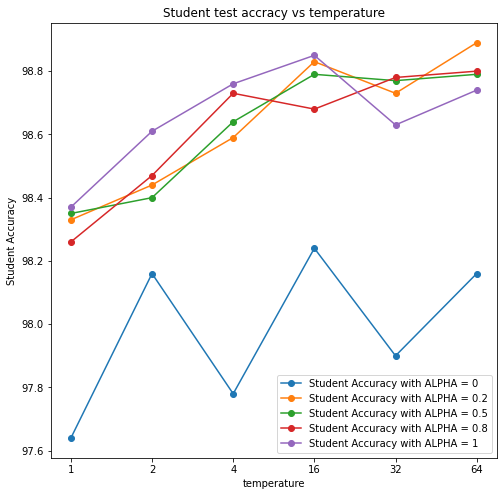

FileNotFoundError: ignored

<Figure size 432x288 with 0 Axes>

In [8]:
# your code start from here for step 6
# Plot a curve representing student test accuracy vs. temperature hyperparameters (T = 1,2,4,16,32,
# and 64) when the task balance parameter is 0.5
import matplotlib.pyplot as plt


Temperatures = [1,2,4,16,32,64]
ALPHAS=[0, 0.2, 0.5, 0.8, 1]
student_accuracy_matrixes = {}
for a in ALPHAS:
  ALPHA = a
  accracy_among_t = []
  for t in Temperatures:
    DISTILLATION_TEMPERATURE = t
    tf.keras.backend.clear_session()
    fc_model = tf.keras.models.clone_model(fc_model)
    matrix = train_and_evaluate(fc_model, compute_student_loss)
    accracy_among_t.append(matrix.get('Student Accuracy').numpy())
  student_accuracy_matrixes[ALPHA] =  accracy_among_t  


acc_0 = student_accuracy_matrixes.get(ALPHAS[0])
acc_1 = student_accuracy_matrixes.get(ALPHAS[1])
acc_2 = student_accuracy_matrixes.get(ALPHAS[2])
acc_3 = student_accuracy_matrixes.get(ALPHAS[3])
acc_4 = student_accuracy_matrixes.get(ALPHAS[4])

plt.figure(figsize=(8, 8))
plt.title('Student test accracy vs temperature')
plt.xlabel('temperature')
plt.ylabel('Student Accuracy')
xi = list(range(len(Temperatures)))

plt.plot(acc_0,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0')
plt.plot(acc_1,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.2')
plt.plot(acc_2,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.5')
plt.plot(acc_3,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.8')
plt.plot(acc_4,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 1')

plt.xticks(xi, Temperatures)
plt.legend(loc='lower right')
# plt.savefig('/content/images_minist/accuracyVStemperatures.png')
plt.show()


FileNotFoundError: ignored

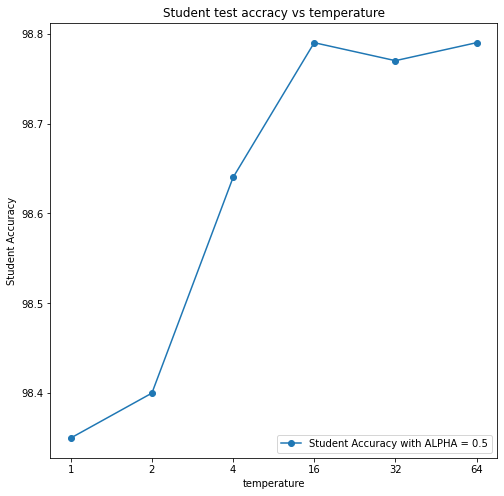

In [9]:
acc_0 = student_accuracy_matrixes.get(ALPHAS[0])
acc_1 = student_accuracy_matrixes.get(ALPHAS[1])
acc_2 = student_accuracy_matrixes.get(ALPHAS[2])
acc_3 = student_accuracy_matrixes.get(ALPHAS[3])
acc_4 = student_accuracy_matrixes.get(ALPHAS[4])

plt.figure(figsize=(8, 8))
plt.title('Student test accracy vs temperature')
plt.xlabel('temperature')
plt.ylabel('Student Accuracy')
xi = list(range(len(Temperatures)))

# plt.plot(acc_0,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0')
# plt.plot(acc_1,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.2')
plt.plot(acc_2,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.5')
# plt.plot(acc_3,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 0.8')
# plt.plot(acc_4,linestyle='-', marker='o', label='Student Accuracy with ALPHA = 1')

plt.xticks(xi, Temperatures)
plt.legend(loc='lower right')
# plt.savefig('/content/images_minist/accuracyVStemperatures(alpha=0.5).png')
plt.show()


# Train student from scratch

In [10]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()
fc_model_no_distillation.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(10))
fc_model_no_distillation.summary()
# your code start from here for step 7



#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits)
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

# accracy is about 97%-98%, which is slower than the accracy of student model with KD


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 784)               615440    
                                                                 
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1: Class_accuracy: 96.68%
Total time per epoch: 4.87 seconds
Epoch 2: Class_accuracy: 97.45%
Total time per epoch: 4.67 seconds
Epoch 3: Class_accuracy: 97.71%
Total time p

{'Student Accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=98.17>}

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
!pip install keras-flops
from keras_flops import get_flops

In [ ]:
# your code start from here for step 8

# count number of parameters of Teacher and student model
cnn_model.summary() # 1,404,682
fc_model.summary()  #1,238,730

# calculate FLOPs of the teacher and student model
teacher_flops = get_flops(cnn_model, batch_size=BATCH_SIZE)
print("The number of FLOPs of the teacher model:", teacher_flops)

student_flops = get_flops(fc_model, batch_size=BATCH_SIZE)
print("The number of FLOPs of the student model:", student_flops)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dropout_2 (Dropout)         (None, 10816)            

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


The number of FLOPs of the teacher model: 7758170624
The number of FLOPs of the student model: 633825792


# Implementing the state-of-the-art KD algorithm

In [21]:
# your code start from here for step 12
# implement KD using others novel idea

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
#adding convolution layer
cnn_model.add(tf.keras.layers.Conv2D(32,(3,3), strides=(1, 1), padding="same", activation='relu', input_shape=(28,28,1)))
#adding pooling layer
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1))
#adding convolution layer
cnn_model.add(tf.keras.layers.Conv2D(64,(3,3), strides=(1, 1), padding="same", activation='relu'))
#adding pooling layer
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
#adding fully connected layer
cnn_model.add(tf.keras.layers.Flatten())
#randomly turn neurons on or off to improve convergence
cnn_model.add(tf.keras.layers.Dropout(0.5))
#fully connected to get all relavent data
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
#one more dropout
cnn_model.add(tf.keras.layers.Dropout(0.5))
#adding output layer
# cnn_model.add(tf.keras.layers.Dense(10))
# each class is divided into 5 subclasses
cnn_model.add(tf.keras.layers.Dense(50))
cnn_model.summary()

# your code start from here for step 3

# Build fully connected student.
fc_model = tf.keras.Sequential()

fc_model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
#adding output layer
# fc_model.add(tf.keras.layers.Dense(10))
# each class is divided into 5 subclasses
fc_model.add(tf.keras.layers.Dense(50))
fc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 10816)            

In [22]:
# create sublabels for each image
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], 5 * builder.info.features['label'].num_classes)
  return image, subclass_labels

def preprocess_test(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels

mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess_test).batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [23]:
ALPHA = 0.5
BETA = 0.5
TEMPERATURE = 4

In [24]:
def compute_teacher_loss(images, labels):
  # forward pass of teacher
  # prediction of teacher model
  subclass_logits = cnn_model(images, training=True)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits)
  v = subclass_logits.numpy()
  v_norm = v/np.linalg.norm(v)

  n=len(v)
  T=1
  loss_mat=np.zeros([n,n])
  #e^(vi'*vj/T) matrix
  for i in range(n):
    vi = v_norm[i]
    for j in range(n):
      vj = v_norm[j]
      loss_mat[i][j]=np.exp(np.dot(np.transpose(v[i]), v[j])/T)

  loss_aux = 1/n*np.sum(np.log(np.sum(loss_mat,axis=1)))-1/T-np.log(n)

  loss = cross_entropy_loss_value + BETA * loss_aux

  return loss


In [25]:

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2


def compute_student_loss(images, labels):
  student_subclass_logits = fc_model(images, training=True)
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.categorical_crossentropy(labels, student_subclass_logits,  from_logits=True)
  loss= ALPHA*distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value
  return loss

In [26]:
@tf.function

def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  # class_logits = model(images, training=False)
  pred_labels = model(images, training=False)
  # pred = class_logits.numpy()
  # new_pre = []
  
  # for n in range(len(pred)):
  #   pred_10 = []
  #   for i in range(0, 50, 5):
  #     pred_10.append(sum(pred[n][i:i+5]))
  #     # print(pred_10)
  #   new_pre.append(pred_10)
  
  # pred_labels = tf.convert_to_tensor(new_pre, dtype=tf.float32)
  
  value= tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(pred_labels, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(pred_labels, -1), tf.argmax(labels, -1)
  return value


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  optimizer = tf.optimizers.Adam(learning_rate=0.001)
  accuracy_matrix={}
  time_matrix=[]
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    start_time = time.time()
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num,a, b = compute_num_correct(model, images, labels)
      num_correct += num
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    accuracy_matrix.update({"Student Accuracy": num_correct / num_total * 100})
    epoch_time = time.time() - start_time
    time_matrix.append(epoch_time)
    print("Total time per epoch: {0:.2f} seconds".format(epoch_time))
  total_time = np.sum(time_matrix)
  print("Total time of training this model: {0:.2f} seconds".format(total_time))
  return accuracy_matrix
    


In [28]:
NUM_EPOCHS = 15

history = train_and_evaluate(cnn_model, compute_teacher_loss)
# Class_accuracy: 99.20%
# Total time of training this model: 2737.23 seconds

Epoch 1: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Class_accuracy: 97.74%
Total time per epoch: 142.49 seconds
Epoch 2: Class_accuracy: 98.51%
Total time per epoch: 162.87 seconds
Epoch 3: Class_accuracy: 98.77%
Total time per epoch: 169.02 seconds
Epoch 4: Class_accuracy: 98.77%
Total time per epoch: 170.26 seconds
Epoch 5: Class_accuracy: 98.98%
Total time per epoch: 182.97 seconds
Epoch 6: Class_accuracy: 98.89%
Total time per epoch: 190.04 seconds
Epoch 7: Class_accuracy: 99.05%
Total time per epoch: 191.47 seconds
Epoch 8: Class_accuracy: 98.96%
Total time per epoch: 191.44 seconds
Epoch 9: Class_accuracy: 98.96%
Total time per epoch: 181.26 seconds
Epoch 10: Class_accuracy: 99.19%
Total time per epoch: 190.96 seconds
Epoch 11: Class_accuracy: 99.12%
Total time per epoch: 194.01 seconds
Epoch 12: Class_accuracy: 99.20%
Total time per epoch: 192.90 seconds
Epoch 13: Class_accuracy: 99.21%
Total time per epoch: 193.98 seconds
Epoch 14: Class_accuracy: 99.23%
Total time per epoch: 192.93 seconds
Epoch 15: Class_accuracy: 99.20%
Total

In [29]:
student_his = train_and_evaluate(fc_model, compute_student_loss)
# Class_accuracy: 98.79%
# Total time of training this model: 107.36 seconds

Epoch 1: Class_accuracy: 96.30%
Total time per epoch: 7.32 seconds
Epoch 2: Class_accuracy: 97.81%
Total time per epoch: 7.19 seconds
Epoch 3: Class_accuracy: 98.16%
Total time per epoch: 7.51 seconds
Epoch 4: Class_accuracy: 98.40%
Total time per epoch: 7.05 seconds
Epoch 5: Class_accuracy: 98.36%
Total time per epoch: 7.16 seconds
Epoch 6: Class_accuracy: 98.60%
Total time per epoch: 7.26 seconds
Epoch 7: Class_accuracy: 98.62%
Total time per epoch: 7.09 seconds
Epoch 8: Class_accuracy: 98.67%
Total time per epoch: 7.02 seconds
Epoch 9: Class_accuracy: 98.75%
Total time per epoch: 7.06 seconds
Epoch 10: Class_accuracy: 98.72%
Total time per epoch: 7.29 seconds
Epoch 11: Class_accuracy: 98.87%
Total time per epoch: 7.13 seconds
Epoch 12: Class_accuracy: 98.81%
Total time per epoch: 7.03 seconds
Epoch 13: Class_accuracy: 98.74%
Total time per epoch: 7.01 seconds
Epoch 14: Class_accuracy: 98.82%
Total time per epoch: 7.03 seconds
Epoch 15: Class_accuracy: 98.79%
Total time per epoch: 7.

# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
